# Problem Set 7

In [6]:
using Pkg
Pkg.activate(@__DIR__)

Pkg.add("Interpolations")
# Load packages
using QuantEcon
using QuantEcon: solve
using Parameters: @unpack
using ForwardDiff: gradient, hessian
using FiniteDifferences: grad, central_fdm
using Statistics: mean
using LinearAlgebra: dot, norm
using Plots
using DataFrames
using Binscatters
using Optim
using Optim: optimize, minimizer, f_calls
using TexTables
using LogExpFunctions
using ProgressMeter
using Interpolations
using LaTeXStrings
using DataFrames
using Plots

  Activating new project at `/arthurfjohnson/PNM-for-Econ-Group-1`
   Resolving package versions...


Base.IOError: IOError: mkdir("/arthurfjohnson"; mode=0o777): read-only file system (EROFS)

## Problem 1
### Problem 1a

UndefVarError: UndefVarError: `mount` not defined

In [8]:
# Model parameters
params = (
    β = 0.95,
    δ = 0.05,
    σ = 2.0,
    ν = 2.0,
    α = 1/3,
    A = 1.0,
    ϕ = 1.0)

# Functions
@unpack β, δ, σ, ν, α, A, ϕ = params
u(c, l) = c^(1-σ)/(1-σ) - ϕ*l^(1+ν)/(1+ν)
f(k, l) = A*k^(α)*l^(1-α)

k_grid = range(1e-6, 10, 50)
l_grid = range(0, 1, 50)

# Value function iteration
function vfi(v0, n_iter=1000, tol=1e-6)
    @unpack β, δ, σ, ν, α, A, ϕ = params
    v = copy(v0)
    log_errors_vfi = zeros(n_iter)
    for i in 1:n_iter
        v_new = similar(v)
        for (i_k, k) in enumerate(k_grid)
            max_val = -Inf
            for l in l_grid
                cons = f(k, l) + (1-δ)*k
                for k_p in k_grid
                    if cons >= k_p
                        c = cons - k_p
                        obj_val = u(c, l) + β * v[searchsortedlast(k_grid, k_p)]
                        max_val = max(max_val, obj_val)
                    end
                end
            end
            v_new[i_k] = max_val
        end
        log_errors_vfi[i] = log10(maximum(abs.(v_new .- v)))
        v = v_new
    end
    return v, log_errors_vfi
end

# Initial guess
v0 = ones(length(k_grid))

@time v_star, log_error_vfi = vfi(v0)

function calculate_policy(v_star)
    @unpack β, δ, σ, ν, α, A, ϕ = params
    c_policy = zeros(length(k_grid))
    l_policy = zeros(length(k_grid))
    k_policy = zeros(length(k_grid))
    
    for (i_k, k) in enumerate(k_grid)
        max_val = -Inf
        optimal_c = optimal_l = optimal_k_p = 0
        
        for l in l_grid
            for k_p in k_grid
                c = f(k, l) + (1-δ)*k - k_p  # Define c here
                if c > 0
                    val = u(c, l) + β * v_star[searchsortedlast(k_grid, k_p)]
                    if val > max_val
                        max_val = val
                        optimal_c, optimal_l, optimal_k_p = c, l, k_p
                    end
                end
            end
        end
        
        c_policy[i_k] = optimal_c
        l_policy[i_k] = optimal_l
        k_policy[i_k] = optimal_k_p
    end
    
    return c_policy, l_policy, k_policy
end

 40.380429 seconds (1.49 G allocations: 24.110 GiB, 1.94% gc time, 0.13% compilation time)


calculate_policy (generic function with 1 method)

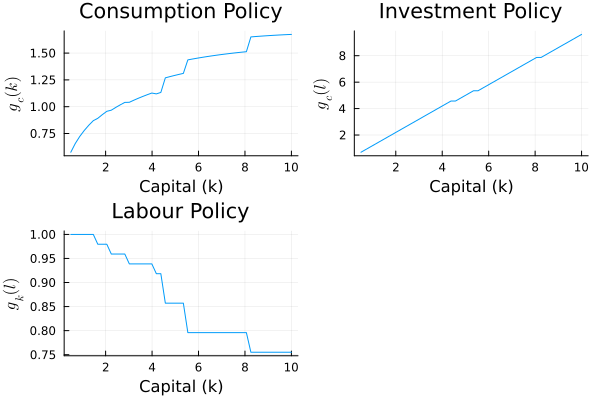

In [10]:
# Plot
c_policy, l_policy, k_policy = calculate_policy(v_star)

consumption_p = plot(k_grid, c_policy, label="Consumption", xlabel="Capital (k)", ylabel="\$g_c(k)\$", title = "Consumption Policy")
labour_p = plot(k_grid, l_policy, label="Labour Supply", xlabel="Capital (k)", ylabel="\$g_c(l)\$", title = "Labour Policy")
investment_p = plot(k_grid, k_policy, label="Investment", xlabel="Capital (k)", ylabel="\$g_k(l)\$", title = "Investment Policy")

plot(consumption_p, investment_p, labour_p, legend=false)

### Problem 1b

In [1]:
v0 = ones(length(k_grid))
c_policy_initial = rand(length(k_grid)).*maximum(k_grid)
l_policy_initial = rand(length(k_grid))
k_policy_initial = rand(length(k_grid)).*maximum(k_grid)

function policy_iteration(v0, c_policy_initial, l_policy_initial, k_policy_initial; n_iter=1000, tol=1e-6, policy_steps_vector)
    @unpack β, δ, σ, ν, α, A, ϕ = params
    log_errors_all = Dict{Int, Vector{Float64}}()
    
    for policy_steps in policy_steps_vector
        println("------------- $policy_steps policy steps --------------")
        log_errors = zeros(n_iter)
        v = copy(v0)
        c_policy = copy(c_policy_initial)
        l_policy = copy(l_policy_initial)
        k_policy = copy(k_policy_initial)
        
        @time begin
            for i in 1:n_iter
                v_new = similar(v)
                for (i_k, k) in enumerate(k_grid)
                    max_val = -Inf
                    for (i_l, l) in enumerate(l_grid)
                        for k_p in k_grid
                            c = f(k, l) + (1-δ)*k - k_p
                            if c > 0
                                val = u(c, l) + β * v[searchsortedlast(k_grid, k_p)]
                                if val > max_val
                                    max_val = val
                                    c_policy[i_k] = c
                                    l_policy[i_k] = l
                                    k_policy[i_k] = k_p
                                end
                            end
                        end
                    end
                    v_new[i_k] = max_val
                end

                for p_step in 2:policy_steps
                    for (i_k, k) in enumerate(k_grid)
                        max_val = -Inf
                        for (i_l, l) in enumerate(l_grid)
                            for k_p in k_grid
                                c = f(k, l) + (1-δ)*k - k_p
                                if c > 0
                                    val = u(c, l) + β * v_new[searchsortedlast(k_grid, k_p)]
                                    if val > max_val
                                        max_val = val
                                        c_policy[i_k] = c
                                        l_policy[i_k] = l
                                        k_policy[i_k] = k_p
                                    end
                                end
                            end
                        end
                        v_new[i_k] = max_val
                    end
                end

                log_errors[i] = log10(maximum(abs.(v_new .- v)))
                dist = maximum(abs.(v_new .- v))
                v = v_new
                if dist < tol
                    log_errors = log_errors[1:i]
                    println("Converged in $i iterations with error $dist ")
                    break
                end
            end
        end
        log_errors_all[policy_steps] = log_errors
        println("\n")
    end

    return v, c_policy, l_policy, k_policy, log_errors_all
end

policy_steps_vector = [2, 5, 10]
v, c_policy, l_policy, k_policy, log_errors_all = policy_iteration(v0, c_policy_initial, l_policy_initial, k_policy_initial; policy_steps_vector=policy_steps_vector)

UndefVarError: UndefVarError: `k_grid` not defined

In [ ]:
plot()
for (policy_steps, log_errors) in log_errors_all
    iterations = 1:length(log_errors)
    plot!(iterations, log_errors, label="Policy steps: $policy_steps")
end
plot!()
xlabel!("Number of Iterations")
ylabel!("\$Log_{10} ϵ\$")
title!("Convergence of VFI vs. PFI")
display(plot!())